# CUISINE CLASSIFICATION USING RANDOM FOREST AND XGBOOST

This is an attempt to reconstruct the experiment in the following scientific article:
"Cuisine Prediction based on Ingredients using Tree Boosting Algorithms" by R. M. Rahul Venkatesh Kumar, M. Anand Kumar, Soman Kp found here: https://www.researchgate.net/publication/311853082_Cuisine_Prediction_based_on_Ingredients_using_Tree_Boosting_Algorithms

### Github repositories used:

https://github.com/tunglin55/Recipe2Cuisine/blob/master/Recipe2Cuisine.ipynb (Random forest) <br>
https://github.com/Ramoooona/Machine-Learning---What-s-Cooking (XGBoost) <br>
https://github.com/madhavambati/Cuisine-classification-using-Ingredients/blob/master/what-s-cooking-a-basic-simple-model.ipynb 

In [30]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import xgboost as xgb
from xgboost import XGBClassifier
import time
import re

from itertools import chain
from scipy import stats
from nltk.stem import WordNetLemmatizer
from Recipe2Cuisine_functions import preprocess, plot_confusion_matrix

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score

from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline, Pipeline
import warnings
from sklearn.linear_model import LogisticRegression

### Import json train file
Here we can see example of the data used

In [31]:
trainFile = "train.json"
testFile = "test.json"

d_train = pd.read_json(trainFile)
d_test = pd.read_json(testFile)
d_train.head()

,id,cuisine,ingredients
0,10259,greek,"[romaine lettuce, black olives, grape tomatoes..."
1,25693,southern_us,"[plain flour, ground pepper, salt, tomatoes, g..."
2,20130,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, g..."
3,22213,indian,"[water, vegetable oil, wheat, salt]"
4,13162,indian,"[black pepper, shallots, cornflour, cayenne pe..."


In [32]:
d_test.head()

,id,ingredients
0,18009,"[baking powder, eggs, all-purpose flour, raisi..."
1,28583,"[sugar, egg yolks, corn starch, cream of tarta..."
2,41580,"[sausage links, fennel bulb, fronds, olive oil..."
3,29752,"[meat cuts, file powder, smoked sausage, okra,..."
4,35687,"[ground black pepper, salt, sausage casings, l..."


### Show info of data and it's composition

In [33]:
d_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39774 entries, 0 to 39773
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           39774 non-null  int64 
 1   cuisine      39774 non-null  object
 2   ingredients  39774 non-null  object
dtypes: int64(1), object(2)
memory usage: 932.3+ KB


In [34]:
d_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9944 entries, 0 to 9943
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           9944 non-null   int64 
 1   ingredients  9944 non-null   object
dtypes: int64(1), object(1)
memory usage: 155.5+ KB


### Check if contains NaN anywhere

In [35]:
d_train.isna().any()

id             False
cuisine        False
ingredients    False
dtype: bool

In [36]:
d_test.isna().any()

id             False
ingredients    False
dtype: bool

# EDA

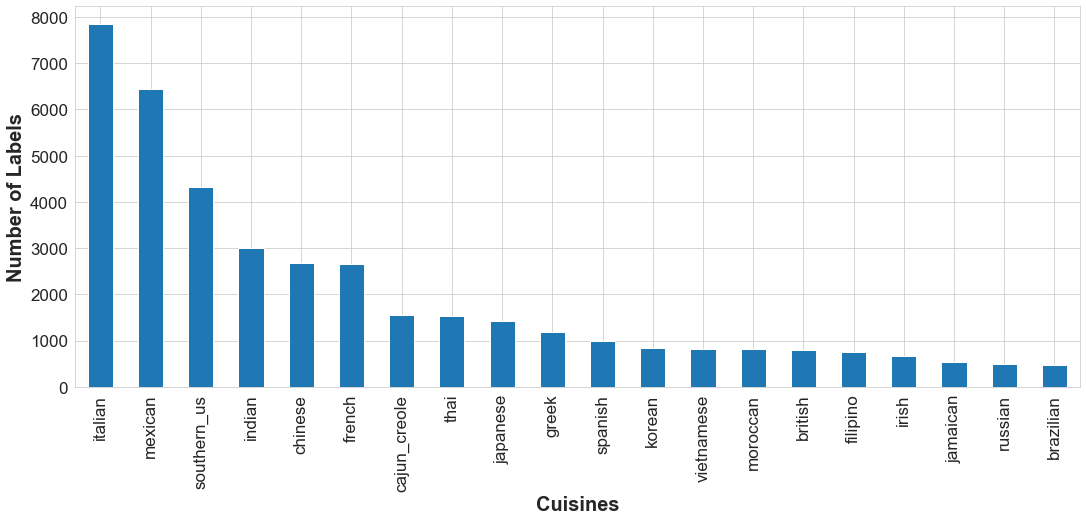

In [37]:
# Counts of the number of cuisine labels 
fig, ax = plt.subplots()
fig.set_size_inches(18, 7)
d_train['cuisine'].value_counts().plot(kind='bar');
sns.set_style("whitegrid") 
plt.xticks(rotation = '90', fontsize = 17);
plt.yticks(fontsize = 17);
ax.set_xlabel('Cuisines', fontsize = 20, weight='bold');
ax.set_ylabel('Number of Labels', fontsize = 20, weight='bold');

In [38]:
# Count of how many ingredients per receipe in each cuisine 
d_train['Count'] = d_train['ingredients'].apply(len)
d_train.head()

d_test['Count'] = d_test['ingredients'].apply(len) #TODO
#d_test.head()

## Preprocessing

In [39]:
for item in d_train['ingredients']:
    #item.replace("-", "_")
    for s in item:
        re.sub(r"-", "_", s)
        re.sub(r"[^a-z0-9_ ]", "", s)
        
for item in d_test['ingredients']:
    #item.replace("-", "_")
    for s in item:
        re.sub(r"-", "_", s)
        re.sub(r"[^a-z0-9_ ]", "", s)




# Clean data using word lemmatization
d_train['ingredients_clean']=d_train['ingredients'].apply(preprocess)
d_train.head()

d_test['ingredients_clean']=d_test['ingredients'].apply(preprocess) #TODO
d_test.head()

,id,ingredients,Count,ingredients_clean
0,18009,"[baking powder, eggs, all-purpose flour, raisi...",6,"baking powder,egg,all purpose flour,raisin,mil..."
1,28583,"[sugar, egg yolks, corn starch, cream of tarta...",11,"sugar,egg yolks,corn starch,cream of tartar,ba..."
2,41580,"[sausage links, fennel bulb, fronds, olive oil...",6,"sausage links,fennel bulb,frond,olive oil,cuba..."
3,29752,"[meat cuts, file powder, smoked sausage, okra,...",21,"meat cuts,file powder,smoked sausage,okra,shri..."
4,35687,"[ground black pepper, salt, sausage casings, l...",8,"ground black pepper,salt,sausage casings,leek,..."


In [40]:
# List of unique cuisine
cusine_unique = list(d_train.cuisine.value_counts().index)

# Plot histograms of top 10 ingredients for each cuisine
counter = 0
vocab = [] 

for c in cusine_unique:
    subset = d_train[d_train.cuisine == c]
    sub = []
    
    for item in subset.ingredients_clean:
        sub.append(item.split(','))
    A = pd.DataFrame(list(chain.from_iterable(sub)))

    #vocab.append(A[0].value_counts().iloc[:35].index)
    vocab.append(A[0]) 
    counter = counter + 1

## TF-IDF

In [41]:
# Define vocabulary for each cuisine
all_vocab = set(list(chain.from_iterable(vocab)))

# grab corpus of all ingredients
all_ingredients = []
for items in d_train['ingredients_clean']:
    all_ingredients.append(items)

# Count Frequency of words
cv = CountVectorizer(vocabulary = all_vocab, max_df = 0.8)
wordcount_vector = cv.fit_transform(all_ingredients)
print(wordcount_vector.shape)

tfidf_transformer=TfidfTransformer(smooth_idf = True, use_idf = True)
tfidf_transformer.fit(wordcount_vector)

# Print idf values
df_idf = pd.DataFrame(tfidf_transformer.idf_, index=cv.get_feature_names(),columns=["tf_idf_weights"])
 
# Sort ascending for displaying
df_idf.sort_values(by=['tf_idf_weights']).head()

(39774, 6714)


,tf_idf_weights
salt,1.517975
oil,1.633350
pepper,1.725468
garlic,1.780005
onion,2.012475


In [42]:
# tf-idf scores
tf_idf_vector=tfidf_transformer.transform(wordcount_vector)
feature_names = cv.get_feature_names()

# Get tfidf vector for 51st document
first_document_vector=tf_idf_vector[50]
 
# Print the scores
df = pd.DataFrame(first_document_vector.T.todense(), index=feature_names, columns=["tfidf"])
df.sort_values(by=["tfidf"], ascending=False).head()

,tfidf
sirloin,0.427750
sake,0.412303
mirin,0.385306
shiitake,0.371489
cabbage,0.322448


In [43]:
# To double-check, we could also use TfidfVectorizer which also produces the same results
tfidf_vectorizer=TfidfVectorizer(use_idf = True, vocabulary = all_vocab)
 
# Input all ingredients for vectorizing
tfidf_vectorizer_vectors=tfidf_vectorizer.fit_transform(all_ingredients)

# Get the 51st vector out (for the first document)
first_vector_tfidfvectorizer=tfidf_vectorizer_vectors[50]
 
# Place tf-idf values in a pandas data frame
df = pd.DataFrame(first_vector_tfidfvectorizer.T.todense(), index=tfidf_vectorizer.get_feature_names(), columns=["tfidf"])
df.sort_values(by=["tfidf"],ascending=False).head()

,tfidf
sirloin,0.427750
sake,0.412303
mirin,0.385306
shiitake,0.371489
cabbage,0.322448


In [46]:
# Setting up for modelling 
feature_matrix = tf_idf_vector.toarray()
data_features = pd.DataFrame(feature_matrix)
feature_names = cv.get_feature_names()
data_features.columns = [feature_names]
y = d_train['cuisine']
#y = d_test['ingredients']

## SPLIT TRAIN AND TEST

In [47]:
warnings.filterwarnings('ignore')
X_train, X_test, y_train, y_test = train_test_split(data_features, y, test_size = 0.2, shuffle = True, random_state = 42)
print('Size of feature matrix is: ' + str(X_train.shape))

Size of feature matrix is: (31819, 6714)


### SMOTE

In [48]:
# Initialize SMOTE to correct for class imbalance
sm = SMOTE()

In [49]:
# Logistic Regression Classifier
lr = LogisticRegression()

In [50]:
# Generate a pipeline with SMOTE and logistic regression
pipeline = Pipeline([('sm', sm), ('lr', lr)])

In [51]:
# Grid search parameters for logistic regression
params = {"lr__C" : [0.5, 1, 2], 
          "lr__penalty" : ["l1", "l2"]}

In [52]:
# Perform Grid Search
grid_lr = GridSearchCV(pipeline, params, cv = 3)
#grid_lr.fit(X_train, y_train)

## Random forest

In [100]:
clf = RandomForestClassifier(n_estimators=200,max_depth=200, random_state=0,n_jobs=10)
clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=200, n_estimators=300, n_jobs=10,
                       random_state=0)

In [101]:
#grid_lr.fit(X_train, y_train)

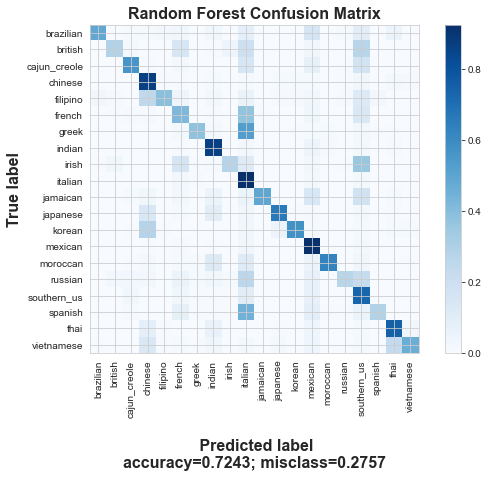

In [102]:
# Classification results using confusion matrix
cuisines = d_train['cuisine'].value_counts().index
labels = np.unique(y_test)

RF_Confusion = confusion_matrix(y_test, clf.predict(X_test), labels=labels) # construct confusion matrix 
plot_confusion_matrix(RF_Confusion, target_names=labels, title = 'Random Forest Confusion Matrix')

In [103]:
# Calculation of weighted F1 score 
RF_f1 = f1_score(y_test, clf.predict(X_test), average = 'weighted') # calculate F1 score

# Calculation of average accuracy score 
RF_acc = clf.score(X_test, y_test)

print('f1-score=%.3f accuracy=%.3f' % (RF_f1, RF_acc))

f1-score=0.708 accuracy=0.724


## XGBoost

In [108]:
start = time.time()

# fit model no training data
#model = XGBClassifier(max_depth=20, learning_rate=0.3, n_estimates=100, objective="multi:softmax", n_jobs=4)
#model = XGBClassifier(max_depth=3, learning_rate=0.3,n_estimators=100,booster='gbtree',n_jobs=4,nthread=4) #1276.1340160369873 seconds 72%
#model = XGBClassifier(max_depth=10, learning_rate=0.3,n_estimators=100,booster='gbtree',n_jobs=4,nthread=4) #4054.4009137153625 seconds 74%
#model = XGBClassifier(max_depth=10, learning_rate=0.1,n_estimators=100,booster='gbtree',n_jobs=4,nthread=4) #3983.120007276535 seconds 73,5%
#model = XGBClassifier(max_depth=20, learning_rate=0.3,n_estimators=100,booster='gbtree',n_jobs=4,nthread=6) #6718.18036699295 seconds 74.13%
#model = XGBClassifier(max_depth=25, learning_rate=0.3, n_estimates=200, objective="multi:softmax", n_jobs=10) #6188.598341703415 seconds 74.20%
#model = XGBClassifier(max_depth=25, learning_rate=0.3, n_estimates=200, objective="multi:softmax",booster='gbtree',num_class=20, n_jobs=10) #6022.938164949417 seconds 74.20%
#model = XGBClassifier(max_depth=20, learning_rate=0.3, n_estimators=200,booster='gbtree',num_class=20, n_jobs=10) #9635.359570264816 seconds 74.41%
model = XGBClassifier(max_depth=5, learning_rate=0.3, n_estimators=200,booster='gbtree',num_class=20, n_jobs=10)

model.fit(X_train, y_train)
# make predictions for test data
y_pred = model.predict(X_test)
end = time.time()
print(str(end - start) + " seconds")


[22:47:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


KeyboardInterrupt: 

In [ ]:
predictions = [value for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))